In [11]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from aldiscore.prediction import utils
from aldiscore import ROOT

In [12]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, *_ = utils.load_features(data_dir)
# feat_df.columns = clean_feat_names
feat_df = feat_df[["is_dna", "num_seqs", "max.seq_length"]]

Dropping 0 NaN rows...


#### run scripts/compute_features.py first!
computes detailed perf_df for feature extraction, stored in logs/perf/...parquet

## Sampled 84 datasets of different sizes in data/benchmarking

In [13]:
data_dir = Path("/hits/fast/cme/bodynems/data/benchmarking")
sample = pd.read_parquet(ROOT.parent / "logs" / "misc" / "runtime_sample.parquet")

perf_dict = {}
for i in range(len(sample)):
    source, dataset = sample.iloc[i, :]
    # os.makedirs(OUT_DIR / source / dataset / "ensemble")
    in_file = data_dir / source / dataset
    for handle in os.listdir(in_file):
        if os.path.isdir(in_file / handle) and not handle == "ensemble":
            bench_file = in_file / handle / "bench_ensemble.txt"
            if os.path.exists(bench_file):
                tool = bench_file.parent.name
                line = open(bench_file).readlines()[1]
                cpu_time = float(line.split("\t")[-1])
                perf_dict[(source, dataset, tool)] = cpu_time
            # else:
            #     print("[NOT DONE]", source, dataset)

In [ ]:
from itertools import product

perf_df = pd.DataFrame(
    perf_dict.values(),
    index=perf_dict.keys(),
    columns=["Time (s)"],
).sort_index()

perf_df.index.names = ["source", "dataset", "tool"]
timeouts = (
    6
    - perf_df[["Time (s)"]]
    .reset_index()
    .drop(["tool"], axis=1)
    .groupby(["source", "dataset"])
    .count()
)
print(timeouts.mean())
print(perf_df.head())

perf_df.to_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time_detailed.parquet")
summary_df = (
    perf_df.reset_index().drop("tool", axis=1).groupby(["source", "dataset"]).sum()
)

# timeouts = timeouts.loc[perf_df.index]

perf_df = perf_df + timeouts * 3600
summary_df.to_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time.parquet")
summary_df.describe()

Time (s)    0.035714
dtype: float64
                                  Time (s)
source    dataset tool                    
arthropod CYP_20  ClustalO           33.19
                  MAFFT_FFT-NS-2      5.71
                  MAFFT_G-INS-i      13.14
                  MAFFT_L-INS-i      13.05
                  Muscle3             9.75


,Time (s)
count,84.000000
mean,5857.289524
std,6907.498488
min,33.020000
25%,71.120000
50%,1578.305000
75%,11102.242500
max,22331.180000


In [28]:
import seaborn as sn
import matplotlib.pyplot as plt

perf_e = pd.read_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time.parquet")
perf_h = pd.read_parquet(ROOT.parent / "logs" / "misc" / "heuristic_time.parquet")
perf_p = pd.read_parquet(ROOT.parent / "logs" / "misc" / "prediction_time.parquet")
idxs = perf_p.index

perf_h.sort_values("Time (s)", ascending=False)

perf_df = pd.concat([perf_e, perf_h, perf_p], join="inner", axis=1)
# perf_df = perf_df.fillna(perf_df.max(axis=0), axis=0)
print(perf_df.shape, "\n", perf_df.isna().mean())
perf_df = perf_df.fillna(3600, axis=0)
perf_df.columns = ["ensemble", "heuristic", "predict"]

perf_df = pd.concat([perf_df, feat_df], join="inner", axis=1)
perf_df["Input Size"] = perf_df["num_seqs"] * perf_df["max.seq_length"]
# perf_df["bin"] = pd.cut(
#     perf_df["Input Size"],
#     bins=[0, 5000, 10000, 50000, 100000, 500000, 1500000],
# )
perf_df.to_parquet(ROOT.parent / "transfer" / "runtime_report.parquet")

(84, 3) 
 Time (s)    0.0
Time (s)    0.0
Time (s)    0.0
dtype: float64


In [30]:
pd.read_parquet(ROOT.parent / "transfer" / "runtime_report.parquet")

ensemble  heuristic    predict  \
source        dataset                                                        
arthropod     CYP_20                          156.56   4.541023   8.952682   
              CYP_307                        1618.67  22.935572  20.544822   
bali3         BBS12037                        136.99   2.511588   7.270550   
              BBS20040                       1062.69   8.601477   9.367815   
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1     41.29   3.118539   6.610344   
...                                              ...        ...        ...   
treebase_v1   26800_3.phy                     531.41   5.085935   5.675323   
              27350_0.phy                    1044.35   9.889267  13.591193   
              27596_39.phy                   4751.14  24.190754  19.139840   
              28078_1.phy                    3294.82   8.539839  14.163398   
              28099_0.phy                    1074.77   6.509556  13.082935   

                                            is_dna  num_seqs  max.seq_length  \
source        dataset                                                          
arthropod     CYP_20                         False        19             494   
              CYP_307                        False       121             642   
bali3         BBS12037                       False        13             509   
              BBS20040                       False        87             338   
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1    True        15              84   
...                                            ...       ...             ...   
treebase_v1   26800_3.phy                     True        46             448   
              27350_0.phy                     True        59             971   
              27596_39.phy                    True        75            1764   
              28078_1.phy                     True        54             971   
              28099_0.phy                     True        33            1713   

                                            Input Size  
source        dataset                                   
arthropod     CYP_20                              9386  
              CYP_307                            77682  
bali3         BBS12037                            6617  
              BBS20040                           29406  
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1        1260  
...                                                ...  
treebase_v1   26800_3.phy                        20608  
              27350_0.phy                        57289  
              27596_39.phy                      132300  
              28078_1.phy                        52434  
              28099_0.phy                        56529  

[84 rows x 7 columns]

\begin{tabular}{lrrr}
\toprule
 & min & mean & max \\
\midrule
0 & 5.22 & 124.18 & 724.26 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3898495/3506492500.py:11: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sn.scatterplot(


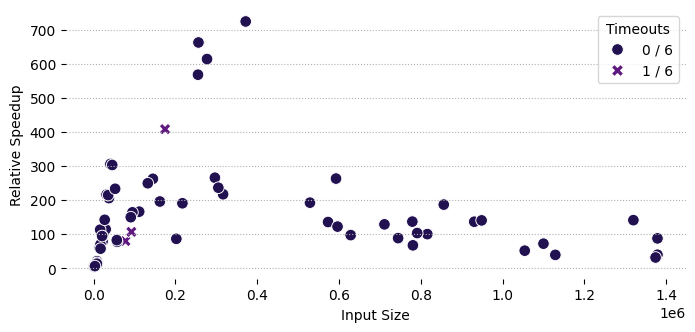

In [7]:
import matplotlib.ticker as mtick

speedup = (perf_df["ensemble"] + perf_df["heuristic"]) / perf_df["predict"]

print(
    speedup.aggregate(["min", "mean", "max"]).to_frame().T.to_latex(float_format="%.2f")
)

timeout_share = ((timeouts).iloc[:, 0]).astype(int)
plt.figure(figsize=(8, 3.5))
ax = sn.scatterplot(
    perf_df,
    x="Input Size",
    y=speedup,
    # hue=timeouts.iloc[:, 0].rename("Timeouts"),
    # style=timeouts.iloc[:, 0].rename("Timeouts"),
    hue=timeout_share,
    style=timeout_share,
    palette=sn.color_palette("magma", 6),
    s=70,
)
ax.grid(linestyle=":", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("Input Size")
ax.set_ylabel("Relative Speedup")
# plt.legend(title="Timeouts")

handles, labels = ax.get_legend_handles_labels()
# Convert integer class labels to integers (if they are not already)
int_labels = [int(l) for l in labels]

percentage_labels = [f"{x} / 6" for x in int_labels]

# Sort by the integer value to preserve order
sorted_items = sorted(zip(int_labels, handles, percentage_labels), key=lambda t: t[0])
sorted_handles = [t[1] for t in sorted_items]
sorted_labels = [t[2] for t in sorted_items]

plt.legend(sorted_handles, sorted_labels, title="Timeouts")

plt.savefig(ROOT.parent / "figures" / "runtime_speedup.svg", bbox_inches="tight")

# ax = sn.barplot(
#     perf_df,
#     x="bin",
#     y=speedup,
#     hue="bin",
#     zorder=2,
#     palette=sn.color_palette("mako", 6),
#     # palette=sn.cubehelix_palette(11),
#     alpha=0.75,
# )
# plt.yscale("log")
# iqr = lambda s: np.percentile(s, 75) - np.percentile(s, 25)
# speedup.groupby(perf_df["bin"]).agg(["mean", "std"]).T.round(2)

In [9]:
perf_df = perf_df.melt(
    id_vars=list(feat_df.columns) + ["bin", "Input Size"],
    value_vars=["ensemble", "heuristic", "predict"],
    var_name="Aspect",
    value_name="Time (s)",
)

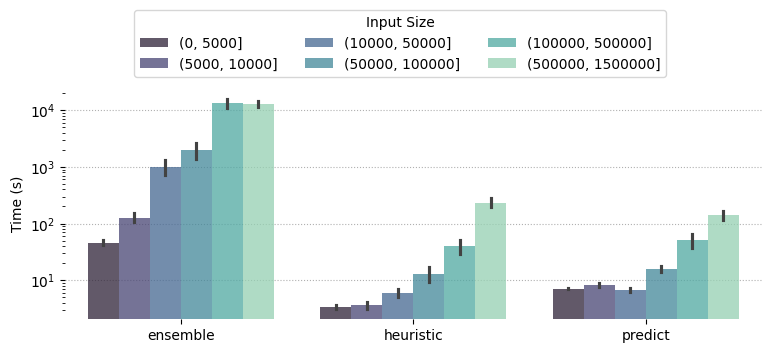

In [10]:
plt.figure(figsize=(9, 3))
ax = sn.barplot(
    perf_df,
    x="Aspect",
    y="Time (s)",
    hue="bin",
    zorder=2,
    palette=sn.color_palette("mako", 6),
    # palette=sn.cubehelix_palette(11),
    alpha=0.75,
)
plt.yscale("log")

ax.grid(linestyle=":", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
sn.move_legend(ax, loc=(0.1, 1.05), ncol=3, title="Input Size")

plt.savefig(ROOT.parent / "figures" / "runtime_comparison.svg", bbox_inches="tight")